In [8]:
library(regclass)
library(ppcor)
library(tseries)

Loading required package: bestglm

Loading required package: leaps

Loading required package: VGAM

Loading required package: stats4

Loading required package: splines

Loading required package: rpart

Loading required package: randomForest

randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.

Important regclass change from 1.3:
All functions that had a . in the name now have an _
all.correlations -> all_correlations, cor.demo -> cor_demo, etc.


Loading required package: MASS

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
data <- read.csv("./dataset_tsmc2014.num_colo.csv")
data <- data[1:288,-1]

In [3]:
head(data)

,Convention.Center,Electronics,Factory,Food...Snack,General.Education.Place,History..Museum...Arts,Hotel,Indoor.Entertainment,Medical.Related.Place,Neighborhood,⋯,Place.for.Sports,Residence,Rest.Area,Restaurant,School,Smoke.Shop,Store..Market...Fair,Transportation,Travel.Related.Place,Vehicle.Related.Place
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,7,1,61,6,29,19,234,19,22,⋯,107,107,0,314,25,0,28,124,5,5
2,1,4,1,75,4,25,19,211,24,33,⋯,85,97,0,289,20,1,24,122,4,11
3,2,4,0,76,2,26,22,185,20,30,⋯,62,92,0,292,17,3,23,102,3,12
4,1,7,0,87,6,18,19,199,22,32,⋯,66,99,1,282,20,9,25,111,1,14
5,1,7,0,77,1,22,26,198,17,26,⋯,78,93,0,248,22,9,23,111,2,9
6,2,17,1,68,6,23,20,151,13,26,⋯,82,86,0,260,19,7,19,93,3,5


In [4]:
vw <- data[1:288,1]

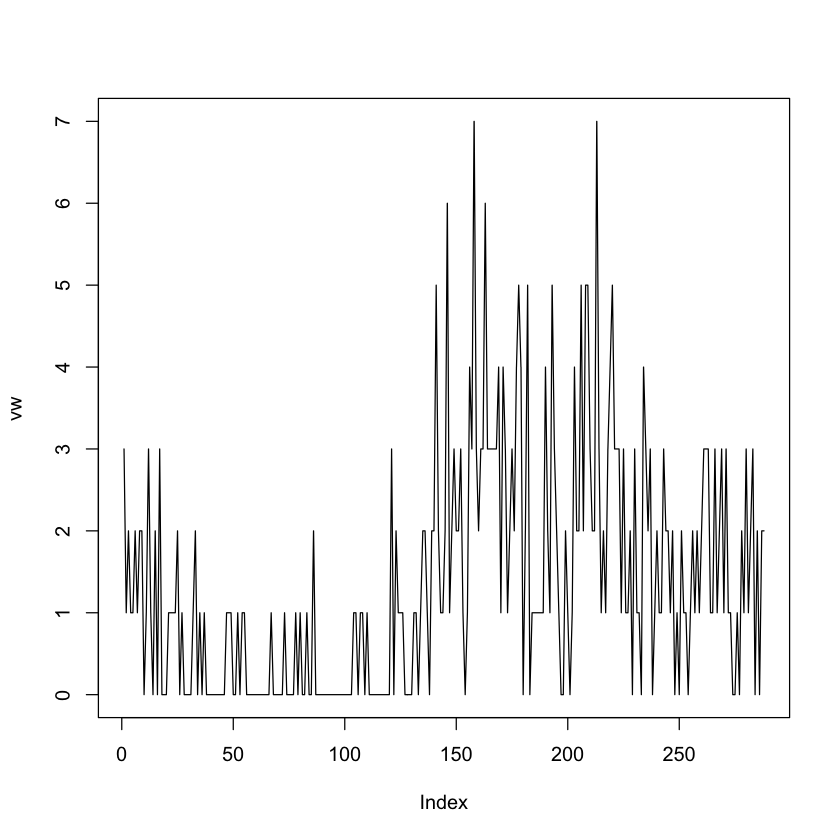

In [5]:
plot(vw,type = "l")

In [6]:
z <- diff(vw)

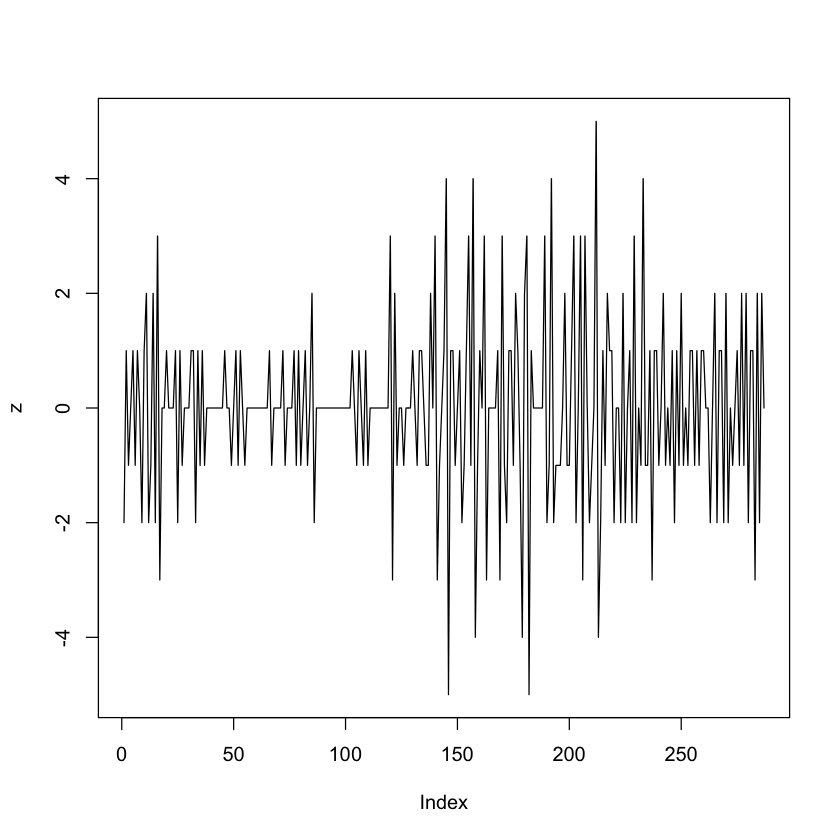

In [7]:
plot(z,type = "l")

In [8]:
adf.test(vw)


	Augmented Dickey-Fuller Test

data:  vw
Dickey-Fuller = -3.4132, Lag order = 6, p-value = 0.05257
alternative hypothesis: stationary


In [9]:
adf.test(z)

Warning message in adf.test(z):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  z
Dickey-Fuller = -8.5416, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


In [9]:
# return the R squared value of guo ~ guo_history + yin_history
self_autoregression <- function(x,y,lags){
    n <- length(x)
    x_hist <- x[1:(n-lags)]
    y_hist <- y[1:(n-lags)]
    Y <- y[(lags+1):n]
    m <- lm(Y~x_hist+y_hist+0)
    return (summary(m)$r.squared)
}

# select best time lags
select_time_lags <- function(z,thres = 0.1){
    pacf = pacf(z,20,,plot = FALSE)
    if(thres==0.1){
        n <- pacf$n.used
        thres <- 1.96/sqrt(n)
    }
    for (i in c(1:20)){
        if (abs(pacf$acf[i])<=thres){
            return (i)
        }
    }
    return (-1)
}

# a helper function to remove an element with certain value from a list
remove <- function(arr,value){
    for(i in c(1:length(arr))){
        if(arr[i]==value){
            r_arr <- arr[-i]
            return (r_arr)
        }
    }
    print("remove failure")
    cat(arr," ",value,"\n")
    return (arr)
}

filter_cause <- function(X,y, thres = 0.1){
    n <- dim(X)[2]
    lags <- c()
    R_squared = c()
    for (i in c(1:n)){
        lag = select_time_lags(X[,i])
        r_sq <- self_autoregression(X[,i],y,lag)
        R_squared = append(R_squared,c(r_sq))
    }

    cause_indices <- c()
    remain <- c(1:n)
    while(length(remain)>0){
        
        j <- which.max(R_squared)
        cause_indices <- append(cause_indices,c(j))
        remain <- remove(remain,j)
        R_squared[j] <- 0
        
        # pruning
        to_remove <- c()
        for(i in remain){
            x=X[,i]
            df <- data.frame(x,y,X[,cause_indices])
#             df <- data.frame(x=X[,j],y=y,z=X[,i])
            pcor <- pcor(df)$estimate[1,2]
            
            if(abs(pcor)<=thres){
                #cat(i," ",pcor,"\n")
                to_remove <- append(to_remove,c(i))
                R_squared[i] <- 0
            }
        }
        for(rm in to_remove){
            remain <- remove(remain,rm)
        }
    }
    return (cause_indices)
}

In [10]:
patterns = c('Convention Center', 'Electronics', 'Factory', 'Food & Snack', 'General Education Place', 'History, Museum & Arts', 'Hotel', 'Indoor Entertainment', 'Medical-Related Place', 'Neighborhood', 'Office',  'Place for Sports', 'Residence',  'Restaurant', 'School', 'Smoke Shop', 'Store, Market & Fair', 'Transportation', 'Travel-Related Place', 'Vehicle-Related Place')

In [20]:
result = ""
for (pattern in patterns){
    direct <- ""
    a <- "/Users/suhong/Desktop/UROP_Data/UROP/FourSquare/dataset_tsmc2014/"
    c <- ".csv"
    path <- paste(a,pattern,c,sep="")
    data <- read.csv(path)
    data <- data[1:287,-1]
    n <- dim(data)[2]
    
    
    X = data[1:287,-n]
    y = data[1:287,n]
#     for (i in 1:n){
#     p <- adf.test(data[1:287,i])$p.value
#     if(p>0.05){
#         print(pattern)
#         print(i)
#         print("oh no!")
#     }
# }
    if(dim(data)[2]==2){direct=c(1)}
    else{direct <- filter_cause(X,y,thres= 0.1)}
#     s <- paste(pattern,direct, sep = "")
#     print(s)
#     result <- paste(result,s,sep=";")
#     print(pattern)
    
#     print(direct)
    s <- paste(";",pattern,":",sep = "")
    cat(s,direct,"")

}

;Convention Center: 2 3 ;Electronics: 2 1 ;Factory: 4 ;Food & Snack: 6 5 2 4 ;General Education Place: 3 5 6 ;History, Museum & Arts: 2 3 ;Hotel: 1 ;Indoor Entertainment: 2 ;Medical-Related Place: 3 4 ;Neighborhood: 4 ;Office: 1 2 ;Place for Sports: 4 1 ;Residence: 4 5 3 ;Restaurant: 1 ;School: 3 2 1 ;Smoke Shop: 1 ;Store, Market & Fair: 4 2 3 ;Transportation: 1 2 3 ;Travel-Related Place: 2 ;Vehicle-Related Place: 1 

In [19]:
paste(";","fuck",":",sep = "")

[1] ";fuck:"

In [1]:
data <- read.csv("./dataset_tsmc2014/convention_center.csv")
data <- data[1:287,-1]

In [2]:
n <- dim(data)[2]
X = data[1:287,-n]
y = data[1:287,n]


Partial autocorrelations of series ‘y’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.453 -0.233 -0.238 -0.052 -0.159 -0.159 -0.130 -0.008 -0.152 -0.149 -0.051 
    12     13     14     15     16     17     18     19     20     21     22 
-0.020  0.022 -0.076 -0.055 -0.025 -0.010 -0.032  0.063  0.064  0.096 -0.007 
    23     24 
-0.072 -0.009 

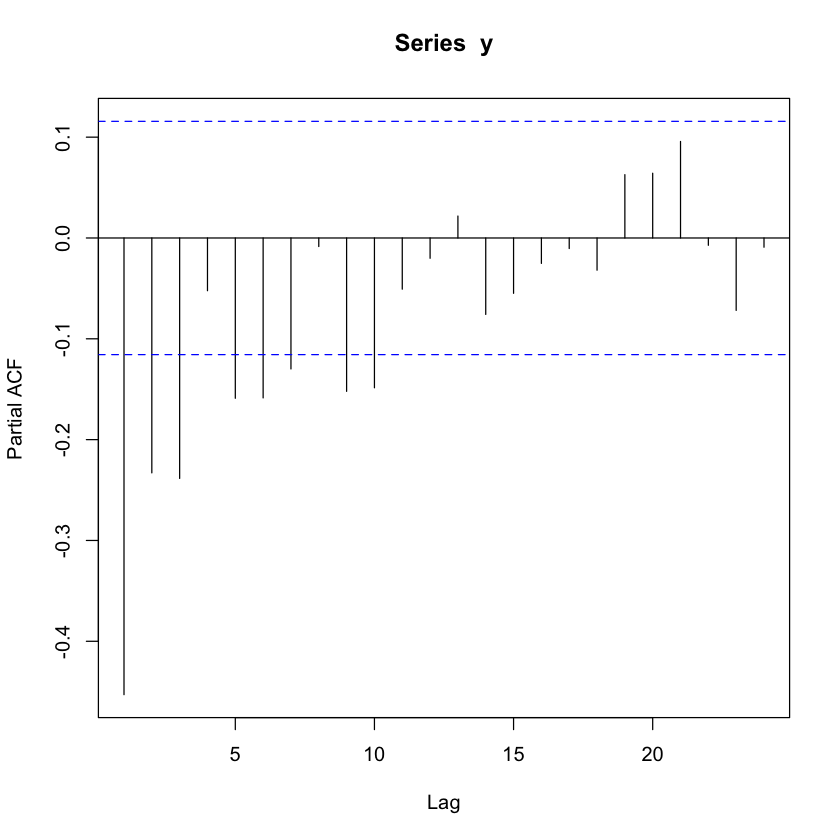

In [4]:
pacf <- pacf(y)
pacf

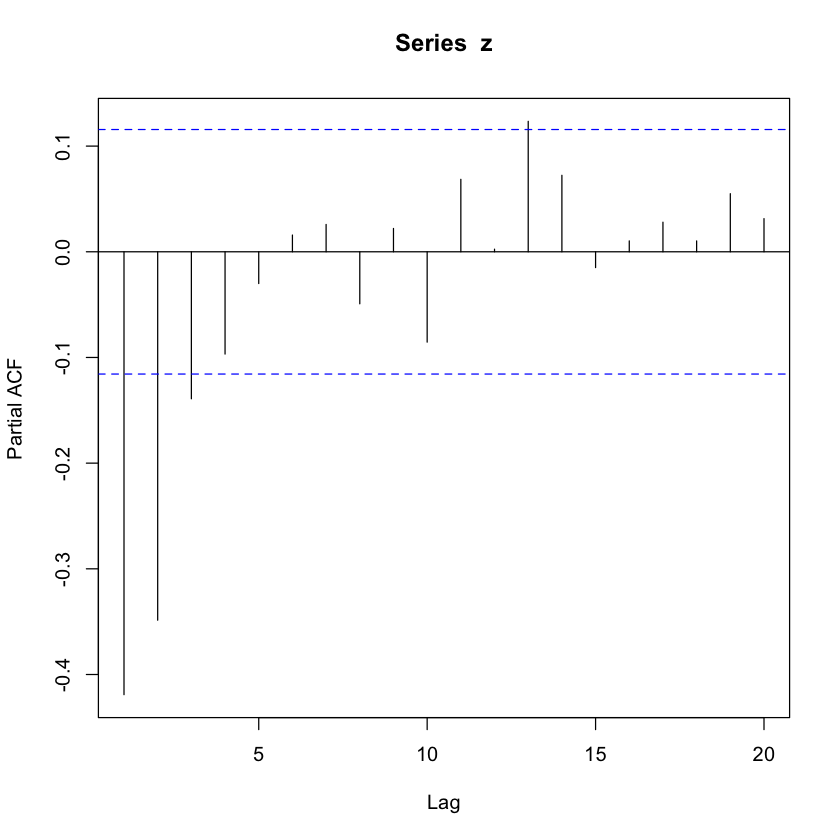

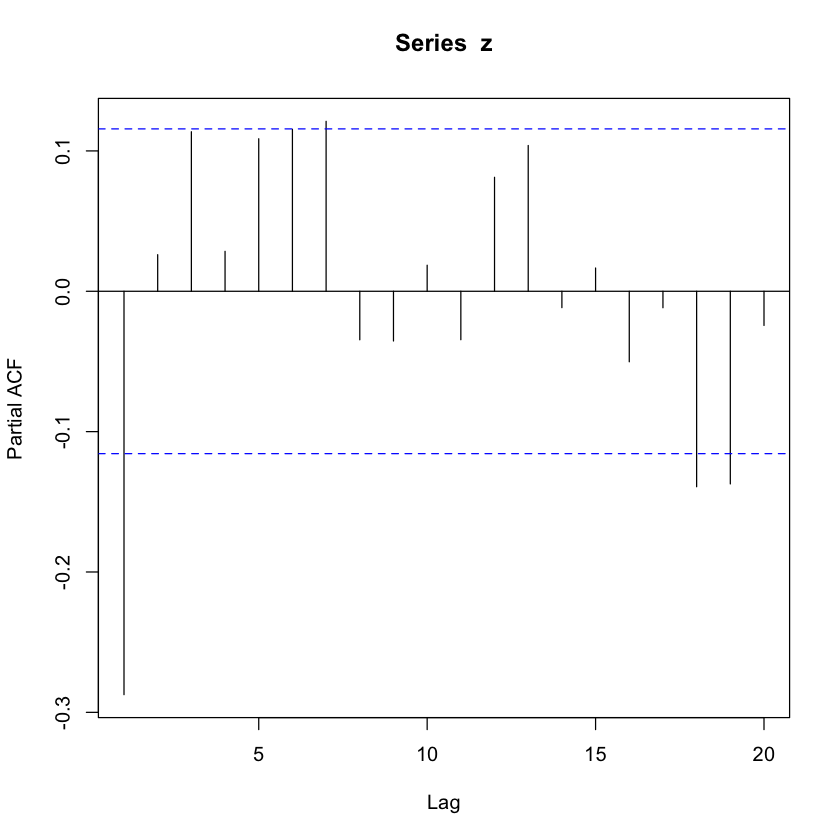

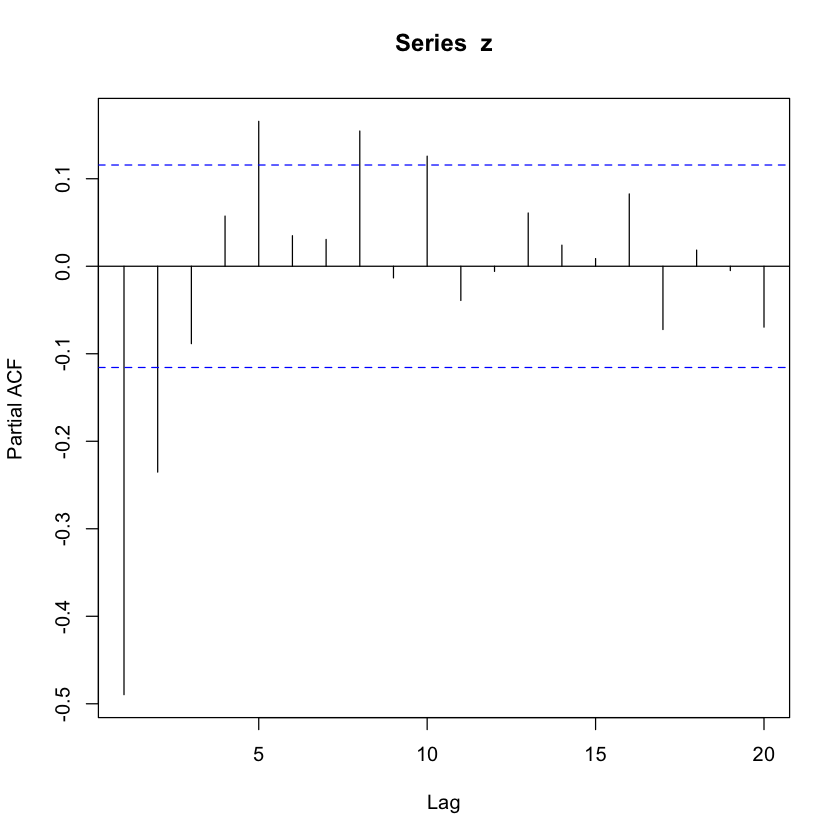

In [159]:
direct <- filter_cause(X,y)

In [160]:
# direct causes for Vehicle-Related Place
direct

[1] 3 1

In [155]:
# direct causes for Travel-Related Place
direct

[1] 2

In [150]:
# direct causes for Transportation
direct

[1] 3 2

In [145]:
# direct causes for Store, Market & Fair
direct

[1] 6 4 5 2 3

In [140]:
# direct causes for Smoke Shop
direct

[1] 1

In [135]:
# direct causes for School
direct

[1] 4 2 1

In [130]:
# direct causes for Restaurant
direct

[1] 2 3

In [125]:
# direct causes for Rest Area
direct

[1] 2

In [120]:
# direct causes for Residenc
direct

[1] 5 3

In [115]:
# direct causes for Place for Sports
direct

[1] 4 1

In [110]:
# direct causes for Outdoor Entertainment
direct

[1] 2

In [105]:
# direct causes for Office
direct

[1] 4 1

In [100]:
# direct causes for Neighborhood
direct

[1] 6 5

In [93]:
# direct causes for Medical-Related Place
direct

[1] 2 4

In [86]:
# direct causes for Indoor Entertainment
direct

[1] 2

In [ ]:
# direct causes for Hotel: factory

In [79]:
# direct causes for History, Museum & Arts
direct

[1] 4 3

In [72]:
# direct causes for General Education Place
direct

[1] 2 5 7

In [65]:
# direct causes for Food & Snack
direct

[1] 6 7 3 5

In [58]:
# direct causes for Factory
direct

[1] 2

In [51]:
# direct causes for eletronics
direct

[1] 3 4 2 5

In [44]:
# direct causes for convention center
direct

[1] 5 3

In [22]:
a <- cat("a","b")
a

a b

NULL

In [26]:
concat <- function(x,causes){
    for (i in causes){
        x <- paste(x,toString(i),sep = " ")
    }
    return (x)
}

In [27]:
b = c(1,2,3)
a = "haha"
concat(a,b)

[1] "haha 1 2 3"

In [35]:
pattern = "Convention Center"
a <- "/Users/suhong/Desktop/UROP_Data/UROP/FourSquare/dataset_tsmc2014/"
    c <- ".csv"
    path <- paste(a,pattern,c,sep="")
    data <- read.csv(path)
    data <- data[1:287,-1]
    n <- dim(data)[2]
    X = data[1:287,-n]
    y = data[1:287,n]
    for (i in 1:n){
    p <- adf.test(data[1:287,i])$p.value
    if(p>0.05){
        print(pattern)
        print(i)
        print("oh no!")
    }
}
X
#     if(dim(X)[2]==1){direct=c(1)}
#     else{direct <- filter_cause(X,y)}
#     s <- concat(pattern,direct)
#     print(s)
#     result <- paste(result,s,sep=";")

Warning message in adf.test(data[1:287, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:287, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:287, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:287, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:287, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:287, i]):
“p-value smaller than printed p-value”


,Indoor.Entertainment,Office,Residence,Transportation,Travel.Related.Place
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-23,3,-10,-2,-1
2,-26,4,-5,-20,-1
3,14,-3,7,9,-2
4,-1,2,-6,0,1
5,-47,0,-7,-18,1
6,50,-14,29,5,-1
7,4,9,-21,15,0
8,-37,-2,14,-10,3
9,93,2,6,-9,-5


In [36]:
head(X)

,Indoor.Entertainment,Office,Residence,Transportation,Travel.Related.Place
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-23,3,-10,-2,-1
2,-26,4,-5,-20,-1
3,14,-3,7,9,-2
4,-1,2,-6,0,1
5,-47,0,-7,-18,1
6,50,-14,29,5,-1


In [42]:
model <- lm(y~.,data= data.frame(y,X[,c(1,2,3)]))

In [43]:
summary(model)


Call:
lm(formula = y ~ ., data = data.frame(y, X[, c(1, 2, 3)]))

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5745 -0.8672  0.0063  0.8932  5.0710 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)  
(Intercept)          -0.0029841  0.0884444  -0.034   0.9731  
Indoor.Entertainment -0.0008371  0.0051647  -0.162   0.8714  
Office                0.0043596  0.0074170   0.588   0.5571  
Residence            -0.0155816  0.0060642  -2.569   0.0107 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.498 on 283 degrees of freedom
Multiple R-squared:  0.02407,	Adjusted R-squared:  0.01372 
F-statistic: 2.327 on 3 and 283 DF,  p-value: 0.07492


In [52]:
t <- VIF(model)[[1]]

In [53]:
t[[1]]

[1] 1.003951

In [54]:
df <- data.frame(y,X[,c(1,2,3)])
head(df)

,y,Indoor.Entertainment,Office,Residence
,<dbl>,<dbl>,<dbl>,<dbl>
1,-2,-23,3,-10
2,1,-26,4,-5
3,-1,14,-3,7
4,0,-1,2,-6
5,1,-47,0,-7
6,-1,50,-14,29


In [55]:
pcor(df)

,y,Indoor.Entertainment,Office,Residence
y,1.000000000,-0.009634422,0.03491869,-0.15098567
Indoor.Entertainment,-0.009634422,1.000000000,0.05047649,0.03543169
Office,0.034918692,0.050476493,1.00000000,0.01208619
Residence,-0.150985669,0.035431685,0.01208619,1.00000000
,y,Indoor.Entertainment,Office,Residence
y,0.00000000,0.8713557,0.5571475,0.01069904
Indoor.Entertainment,0.87135569,0.0000000,0.3959160,0.55136632
Office,0.55714749,0.3959160,0.0000000,0.83901851
Residence,0.01069904,0.5513663,0.8390185,0.00000000
,y,Indoor.Entertainment,Office,Residence
